In [1]:
%%html

<style>
.jp-RenderedHTMLCommon {
    font-size: 12pt;
    font-family: sans-serif;
}
</style>

---
Práctica 2 // M2.851 - Tipología y ciclo de vida de los datos
# Titanic: Machine Learning from Disaster

David Moriano (dmoriano@uoc.edu)

---

## Descripción del dataset 

La madrugada del 15 de abril de 1912, en su viaje inaugural desde Southampton a Nueva York, el RMS Titanic, en la época, el barco más grande del mundo, se hundió en apenas 2 horas y 40 minutos en el Atlántico Norte tras chocar con un iceberg. En este desastre se estima que murieron más de 1500 personas de las 2224 que había a bordo entre pasajeros y tripulación. Uno de los mayores naufragios de la historia ocurridos en tiempo de paz. Esta tragedia conmocionó el mundo y llevó a mejorar la seguridad marítima.


Con esta inspiración compienza la competición educativa de [Kaggle][kaggle:home]:  ["Titanic: Machine Learning from Disaster"][kaggle:titanic] que será objeto de este proyecto. En esta competición se pide aplicar la ciencia de datos para analizar la probabilidad de ser un superviviente del Titanic. En particular, se pide usar aprendizaje automático para predecir que pasajeros sobrevivieron la tragedia.

[kaggle:home]: https://www.kaggle.com
[kaggle:titanic]: https://www.kaggle.com/c/titanic

El dataset está dividido en dos ficheros CSV: 
- `train.csv`: contiene los datos de **891 pasajeros** para análisis y entrenamiento del modelo que clasifique a los pasajeros como supervivientes o víctimas. Este dataset contiene la variable objetivo.
- `test.csv`: contiene los datos de otros **418 pasajeros** para evaluar la precisión del modelo dentro de la competición. Este dataset contiene una lista de pasajeros con las mismas características que `train.csv` pero sin la variable objetivo.

En su conjunto, el dataset contiene datos de 1309 pasajeros y se ha hecho un *split* de, aproximadamente, 70/30 para entrenamiento y validación de los modelos de predicción. Según [wikipedia](https://en.wikipedia.org/wiki/RMS_Titanic#Passengers), el Titanic llevaba aproximadamente 1317 pasajeros (324 en primera clase, 284 en segunda y 709 en tercera), por lo que se puede considerar un dataset bastante completo. La tripulación está fuera del ámbito de este dataset.

En estos ficheros cada fila corresponde con un pasajero distinto y las características disponibles para cada pasajero son las siguientes:

- **Survived**: variable objetivo de tipo binario que indica si el pasajero sobrevivió (1) o no (0). Sólo en `train.csv`.  
- **Pclass**: Categoría del billete que tenía el pasajero. Categórica. En el RMS Titanic había tres clases: Primera (1), Segunda (2) y Tercera (3). En esa época la clase sirve de proxy para el estatus socio-economico del pasajero.
- **Sex**: Sexo del pasajero. Binaria. Hombre (male) y mujer (female).
- **Age**: Edad del pasajero. Fracional si el pasajero tiene menos de 1 año. Las edades estimadas tienen la forma `xx.5`.
- **SibSp**: Número de hermanos o esposos a bordo.
- **Parch**: Número de padres (las niñeras no se incluyen) o hijos a bordo.
- **Ticket**: Número o código del billete. Nominal.
- **Fare**: Precio del pasaje.
- **Cabin**: Número del camarote. Nominal.
- **Embarked**: Puerto de embarque. Categórica. Hay tres puertos: Cherbourg (C), Queenstown (Q) y Southampton (S).

Los ficheros incluyen además un campo `PassengerId` que identifica cada registro dentro del dataset.

En general, una lista de pasajeros forma un dataset que puede ser muy útil desde otros puntos de vista, como, por ejemplo, desde el punto de vista de la seguridad para detectar anomalias o riesgos y, quizás, mejorar los planes de emergencia. Este dataset, en concreto, es interesante desde un punto de vista educativo por ser de un tamaño muy manejable, de fácil comprensión y con abundante información adicional.

En este ejercicio nos planteamos como objetivo responder a la pregunta de la competición, es decir, construir un modelo para predecir si un pasajero dado sobrevivió o no. Para ser más precisos, el objetivo de la competición es imputar los valores perdidos en la variable `Survived`. En el camino intentaremos analizar que factores fueron más relevantes. Trataremos de responder preguntas como:

- ¿Influyen la edad, el sexo o la clase en la supervivencia?
- ¿Influye viajar en familia?
- ¿Influye viajar en grupo?

Hay que notar también que el problema planteado en la competición está resuelto; la lista de los pasajeros y tripulantes que sobrevieron es pública. Ahora, es posible que el dataset haya sido alterado para representar una versión diferente de la realidad, en cualquier caso, para evitar sesgar las prediciones nos restringiremos a los datos proporcionados para la competición.

## Preámbulo -- Imports

In [2]:
# Matplotlib rendering in the notebook
%matplotlib inline

# Common imports
import os
import sys
import re
import math
import random
import time
import datetime
import types
import warnings
import itertools
from glob import glob
# numerical libraries
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
import sklearn
import sklearn_pandas
# plotting
import matplotlib.pyplot as plt
import seaborn as sea
from IPython.display import display, HTML

In [3]:
library_versions = pd.DataFrame(
    columns=['Name', 'Version'],
    data=([('Python', sys.version.split()[0])]
          +[(m.__name__, m.__version__) 
            for m in (np, pd, scipy, plt.matplotlib, sea, sklearn, sklearn_pandas)]))
library_versions

,Name,Version
0,Python,3.6.5
1,numpy,1.14.3
2,pandas,0.23.0
3,scipy,1.1.0
4,matplotlib,2.2.2
5,seaborn,0.8.1
6,sklearn,0.19.1
7,sklearn_pandas,1.6.0


In [4]:
# Apply seaborn styling
sea.set(style='white', palette='Set3')
sea.set_color_codes('muted')
# Tune plots
plt.rcParams['savefig.dpi'] = 96
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

In [5]:
# Disable some irrelevant warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')

## Integración y selección de los datos 

Leemos los datos de los ficheros CSV y realizamos un primer contacto.

In [6]:
DATA_PATH = '../input'

In [7]:
titanic_train = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
titanic_test = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))

In [8]:
titanic_train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [9]:
titanic_test.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


Para evitar fugas de información del conjunto de evaluación que puedan sesgar los modelos predictivos es importante tratar los conjuntos de entrenamiento y evaluación por separado. En particular, es importante realizar los análisis sólo  en el conjunto de entrenamiento. No obstante, para simplificar la limpieza y el análisis de algunas variables necesitamos información sobre la población completa. Por ello vamos a combinar ambos datasets en un único `DataFrame`. Añadiremos una clave (`split`) para identificar el origen de cada registro.

In [10]:
titanic_train['split'] = 'train'
titanic_test['split'] = 'test'

titanic = pd.concat([titanic_train, titanic_test], sort=True)

In [11]:
del titanic_train, titanic_test

## Limpieza de los datos

En la etapa de limpieza vamos a buscar datos nulos, datos erróneos, inconsistencias y datos extremos. Eliminaremos las variables que no sean útiles, resolveremos las inconsistencias que encontremos y trataremos de consolidar el dataset para el análisis. Cabe decir que, a cierto nivel de detalle, la detección y el tratamiento de errores en el dataset se mezclan con el análisis y no es posible hacer una distinción clara.

Empezamos verificando que `PassengerId` es un índice válido y haciendo una primera descripción de los datos.

In [12]:
passengerId = list(titanic['PassengerId'])

# Not duplicates
assert titanic.PassengerId.duplicated().sum() == 0

# Sequential?
print("Is PassengerId monotonic?", sorted(passengerId) == list(range(1, len(titanic) + 1)))
print("Is PassangerId sorted?", passengerId == sorted(passengerId))

Is PassengerId monotonic? True
Is PassangerId sorted? True


In [13]:
titanic.set_index("PassengerId", inplace=True, drop=True, verify_integrity=True)

En segundo lugar vamos a hacer una limpieza básica de las variables de tipo `string` eliminando los espacios vacíos en los extremos.

In [14]:
for c in titanic:
    if titanic[c].dtype == np.object:
        titanic[c] = titanic[c].str.strip()

Podemos obtener una descripción detallada con la función `DataFrame.describe`.

In [15]:
description = titanic.describe(include='all').T
# Some enhancements
description.insert(0, 'dtype', None)
description['count'] = description['count'].astype(int)
for c in titanic:
    description.loc[c, 'unique'] = titanic[c].nunique()
    description.loc[c, 'dtype'] = titanic[c].dtype
# Just to make it clearer
description.fillna('', inplace=True)
display(description)

,dtype,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,float64,1046,98,,,29.8811,14.4135,0.17,21,28,39,80
Cabin,object,295,186,C23 C25 C27,6,,,,,,,
Embarked,object,1307,3,S,914,,,,,,,
Fare,float64,1308,281,,,33.2955,51.7587,0,7.8958,14.4542,31.275,512.329
Name,object,1309,1307,"Connolly, Miss. Kate",2,,,,,,,
Parch,int64,1309,8,,,0.385027,0.86556,0,0,0,0,9
Pclass,int64,1309,3,,,2.29488,0.837836,1,2,3,3,3
Sex,object,1309,2,male,843,,,,,,,
SibSp,int64,1309,7,,,0.498854,1.04166,0,0,0,1,8
Survived,float64,891,2,,,0.383838,0.486592,0,0,0,1,1


En esta descripción vemos varias cosas:

- El dataset de entrenamiento contiene 891 entradas, el de evaluación 418. Vemos ya que hay datos nulos que tendrán que ser tratados.
- En la variable `Cabin` hay celdas con el código de varios camarotes. No hay razón para pensar que esto es un error, pues, es posible que algunos pasajeros hubieran reservado varios camarotes.
- La variable `Ticket` tiene numerosos valores duplicados. Esto tampoco es un error. En la época era común poner a pasajeros de la misma familia, a sus niñeras o a grupos de la tercera clase en el mismo billete. En realidad, este hecho nos puede ayudar a identificar grupos de pasajeros.
- Hay tarifas con valor 0, pero no hay razón para pensar que esto es un error. Por ejemplo, el dueño y el arquitecto del barco viajaban a bordo. Seguramente había más pasajeros que, por una razón u otra, viajan con un billete sin tarifa.
- En la distribución de la variable `Age` no se aprecian valores extremos.
- La variable `Fare` tiene una larga cola a la derecha con un máximo muy alejado de la media.
- En las distribuciones de `SibSp` y `Parch` no se aprecian anomalías.
- Hay nombres duplicados, pero esto no es necesariamente un error.

Validamos las variables categóricas `Pclass`, `Sex` y `Embarked`

In [16]:
assert set(titanic['Pclass']) == {1, 2, 3}, "Error in Pclass"
assert set(titanic['Sex']) == {'male', 'female'}, "Error in Sex"
assert set(titanic['Embarked'].dropna()) == { 'S', 'C', 'Q'}, "Error in Embarked"

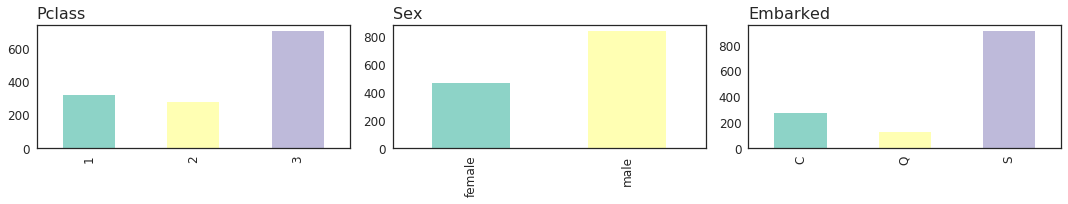

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3))
for i, var_ in enumerate(('Pclass', 'Sex', 'Embarked')):
    var_df = (titanic.reset_index()
               .groupby(var_)['PassengerId']
               .count()
               .to_frame()
               .rename(columns={'PassengerId': 'Passengers'}))
    var_df.Passengers.plot.bar(ax=axes[i])
    axes[i].set(xlabel='')
    axes[i].set_title(var_, loc='left')

In [18]:
print("Cabins:")
print(*sorted(set(titanic['Cabin'].dropna())), sep=', ')

Cabins:
A10, A11, A14, A16, A18, A19, A20, A21, A23, A24, A26, A29, A31, A32, A34, A36, A5, A6, A7, A9, B10, B101, B102, B11, B18, B19, B20, B22, B24, B26, B28, B3, B30, B35, B36, B37, B38, B39, B4, B41, B42, B45, B49, B5, B50, B51 B53 B55, B52 B54 B56, B57 B59 B63 B66, B58 B60, B61, B69, B71, B73, B77, B78, B79, B80, B82 B84, B86, B94, B96 B98, C101, C103, C104, C105, C106, C110, C111, C116, C118, C123, C124, C125, C126, C128, C130, C132, C148, C2, C22 C26, C23 C25 C27, C28, C30, C31, C32, C39, C45, C46, C47, C49, C50, C51, C52, C53, C54, C55 C57, C6, C62 C64, C65, C68, C7, C70, C78, C80, C82, C83, C85, C86, C87, C89, C90, C91, C92, C93, C95, C97, C99, D, D10 D12, D11, D15, D17, D19, D20, D21, D22, D26, D28, D30, D33, D34, D35, D36, D37, D38, D40, D43, D45, D46, D47, D48, D49, D50, D56, D6, D7, D9, E10, E101, E12, E121, E17, E24, E25, E31, E33, E34, E36, E38, E39 E41, E40, E44, E45, E46, E49, E50, E52, E58, E60, E63, E67, E68, E77, E8, F, F E46, F E57, F E69, F G63, F G73, F2, F33, F3

In [19]:
print("Tickets without number:")
# Unique tickets
tickets = sorted(set(titanic['Ticket'].dropna()))
# Tickets without a number
tickets = [ticket for ticket in tickets if not re.search('\d+', ticket)]
# Only ticket without a number is the LINE ticket
print(*tickets, sep=', ')

Tickets without number:
LINE


In [20]:
print(*list(np.random.choice(titanic.Name, 20, replace=False)), sep='\n')

Dennis, Mr. William
Sawyer, Mr. Frederick Charles
Saad, Mr. Khalil
Frolicher, Miss. Hedwig Margaritha
Chip, Mr. Chang
Hays, Miss. Margaret Bechstein
Harper, Rev. John
Thomas, Mr. John
Smith, Mr. Thomas
Boulos, Mrs. Joseph (Sultana)
Harper, Mrs. Henry Sleeper (Myna Haxtun)
Harrison, Mr. William
Earnshaw, Mrs. Boulton (Olive Potter)
Asplund, Master. Clarence Gustaf Hugo
Nourney, Mr. Alfred (Baron von Drachstedt")"
Vander Planke, Mr. Leo Edmondus
Davidson, Mrs. Thornton (Orian Hays)
Zabour, Miss. Thamine
Ali, Mr. Ahmed
Brandeis, Mr. Emil


La variable `Name` parece seguir la siguiente estructura:

    FamilyName, Title. [FirstName] [MiddleName] ["Nick Name"] [(MaidenName)] [("Nick Name")]

Verifiquemos los títulos disponibles.

In [21]:
print(*sorted(titanic.Name.str.extract(r', ([^.]+)\.', expand=False).unique()), sep=', ')

Capt, Col, Don, Dona, Dr, Jonkheer, Lady, Major, Master, Miss, Mlle, Mme, Mr, Mrs, Ms, Rev, Sir, the Countess


In [22]:
titanic.Name[titanic.Name.str.contains('the Countess')]

PassengerId
760    Rothes, the Countess. of (Lucy Noel Martha Dye...
Name: Name, dtype: object

Buscamos otros errores en los nombres.

In [23]:
misspelled_names = titanic.loc[titanic.Name.str.contains('[^\w\s\-\'".,()]|[^\w( ]"| of '), ['Name']]
for row in misspelled_names.iterrows():
    print(f'({row[0]}, {row[1].Name}), ')

(407, Widegren, Mr. Carl/Charles Peter), 
(760, Rothes, the Countess. of (Lucy Noel Martha Dyer-Edwards)), 
(911, Assaf Khalil, Mrs. Mariana (Miriam")"), 
(925, Johnston, Mrs. Andrew G (Elizabeth Lily" Watson)"), 
(927, Katavelas, Mr. Vassilios (Catavelas Vassilios")"), 
(941, Coutts, Mrs. William (Winnie Minnie" Treanor)"), 
(944, Hocking, Miss. Ellen Nellie""), 
(996, Thomas, Mrs. Alexander (Thamine Thelma")"), 
(1000, Willer, Mr. Aaron (Abi Weller")"), 
(1036, Lindeberg-Lind, Mr. Erik Gustaf (Mr Edward Lingrey")"), 
(1117, Moubarek, Mrs. George (Omine Amenia" Alexander)"), 
(1136, Johnston, Master. William Arthur Willie""), 
(1141, Khalil, Mrs. Betros (Zahie Maria" Elias)"), 
(1154, Wells, Mrs. Arthur Henry (Addie" Dart Trevaskis)"), 
(1183, Daly, Miss. Margaret Marcella Maggie""), 
(1196, McCarthy, Miss. Catherine Katie""), 
(1219, Rosenshine, Mr. George (Mr George Thorne")"), 
(1225, Nakid, Mrs. Said (Waika Mary" Mowad)"), 
(1246, Dean, Miss. Elizabeth Gladys Millvina""), 
(1259, 

Vemos varios errores en la posición de las comillas, del punto o el uso de '/' en lugar de los paréntesis. Vamos a corregir estos nombres manualmente.

In [24]:
name_corrections = [
 (407, 'Widegren, Mr. Carl (Charles Peter)'),
 (760, 'Rothes, the Countess of. (Lucy Noel Martha Dyer-Edwards)'),
 (911, 'Assaf Khalil, Mrs. Mariana ("Miriam")'),
 (925, 'Johnston, Mrs. Andrew G (Elizabeth "Lily" Watson)'),
 (927, 'Katavelas, Mr. Vassilios ("Catavelas Vassilios")'),
 (941, 'Coutts, Mrs. William (Winnie "Minnie" Treanor)'),
 (944, 'Hocking, Miss. Ellen "Nellie"'),
 (996, 'Thomas, Mrs. Alexander ("Thamine Thelma")'),
 (1000, 'Willer, Mr. Aaron ("Abi Weller")'),
 (1036, 'Lindeberg-Lind, Mr. Erik Gustaf ("Mr Edward Lingrey")'),
 (1117, 'Moubarek, Mrs. George (Omine "Amenia" Alexander)'),
 (1136, 'Johnston, Master. William Arthur "Willie"'),
 (1141, 'Khalil, Mrs. Betros (Zahie "Maria" Elias)'),
 (1154, 'Wells, Mrs. Arthur Henry ("Addie" Dart Trevaskis)'),
 (1183, 'Daly, Miss. Margaret Marcella "Maggie"'),
 (1196, 'McCarthy, Miss. Catherine "Katie"'),
 (1219, 'Rosenshine, Mr. George ("Mr George Thorne")'),
 (1225, 'Nakid, Mrs. Said (Waika "Mary" Mowad)'),
 (1246, 'Dean, Miss. Elizabeth Gladys "Millvina"'),
 (1259, 'Riihivouri, Miss. Susanna Juhantytar "Sanni"'),
 (1269, 'Cotterill, Mr. Henry "Harry"'),
 (1276, 'Wheeler, Mr. Edwin "Frederick"'),
 (1297, 'Nourney, Mr. Alfred ("Baron von Drachstedt")'),
 (1300, 'Riordan, Miss. Johanna "Hannah"')
]

for pid, corrected_name in name_corrections:
    titanic.loc[pid, 'Name'] = corrected_name


assert titanic.Name.str.contains('[^\w\s\-\'".,()]|[^\w( ]"| of ').any() == False

Verifiquemos los duplicados en la variable `Name`.

In [25]:
titanic[titanic.Name.duplicated(keep=False)].sort_values(['Name'])

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,split
PassengerId,,,,,,,,,,,,
290,22.0,NaN,Q,7.7500,"Connolly, Miss. Kate",0,3,female,0,1.0,370373,train
898,30.0,NaN,Q,7.6292,"Connolly, Miss. Kate",0,3,female,0,NaN,330972,test
697,44.0,NaN,S,8.0500,"Kelly, Mr. James",0,3,male,0,0.0,363592,train
892,34.5,NaN,Q,7.8292,"Kelly, Mr. James",0,3,male,0,NaN,330911,test


Hay dos nombres duplicados, con nombres y apellidos muy comunes. No hay razones para pensar que son errores.

Las variables SibSp (número de hermanos/esposos) y Parch (número de padres/hijos) son más complicadas de verificar. Están relacionadas con la estructura familiar dentro del barco y se complican porque en la época era común que las esposas adoptarán el apellido del marido. Además, la gente se divorcia o enviuda y se vuelve a casar y los nombres cambian. Por desgracia, no podemos asegurar que todos los apellidos de soltera están registrados.

Otro detalle es que para analizar las estructuras familiares es necesario trabajar con toda la población.

Por poner un ejemplo, podemos buscar disparidades dentro de los grupos con el mismo nombre de familia y mismo billete.

In [26]:
x = titanic.drop(columns=['Survived']).copy()

# family name feature
x['FamilyName'] = x.Name.str.extract(r'([^,]+),')
# basic family size (no aunts, uncles, cousins, etc.)
x['FamilySize'] = x['SibSp'] + x['Parch'] + 1
# look for families traveling with the same ticket
z = (x.groupby(['FamilyName', 'Ticket'])['FamilyName'].count()
      .to_frame()
      .rename(columns={'FamilyName': 'FamilyNameCount'})
      .reset_index())
x = x.merge(z,
        how='left', on=['FamilyName', 'Ticket'])
# Look for disparities in the group
x = x[x.FamilyNameCount != x.FamilySize]
x = x[x.duplicated(['FamilyName', 'Ticket', 'Embarked', 'Pclass', 'Fare', 'Cabin'], keep=False)]
x.set_index(['FamilyName', 'Ticket']).sort_index().head(4)

Age Cabin Embarked     Fare  \
FamilyName Ticket                                 
Beckwith   11751   37.0   D35        S  52.5542   
           11751   47.0   D35        S  52.5542   
Bourke     364849  40.0   NaN        Q  15.5000   
           364849  32.0   NaN        Q  15.5000   

                                                               Name  Parch  \
FamilyName Ticket                                                            
Beckwith   11751                      Beckwith, Mr. Richard Leonard      1   
           11751   Beckwith, Mrs. Richard Leonard (Sallie Monypeny)      1   
Bourke     364849                                  Bourke, Mr. John      1   
           364849                     Bourke, Mrs. John (Catherine)      1   

                   Pclass     Sex  SibSp  split  FamilySize  FamilyNameCount  
FamilyName Ticket                                                             
Beckwith   11751        1    male      1  train           3                2  
           11751        1  female      1  train           3                2  
Bourke     364849       3    male      1  train           3                2  
           364849       3  female      1  train           3                2

Tomemos el primer caso, el matrimonio Beckwith. Parece que un padre o un hijo también viajaba en el barco, pero estos son los únicos Beckwith en la lista.

In [27]:
titanic.Name.str.startswith('Beckwith,').sum()

2

Podemos probar con el nombre de soltera de la madre. Pero no hay suerte.

In [28]:
titanic.Name.str.startswith('Monypeny,').sum()

0

Pero si extendemos la búsqueda más allá de los nombres de familia, encontramos a la que seguramente era su hija, Miss. Helen Monypeny, con apellido Newsom. Quizás hija de un matrimonio anterior.

In [29]:
titanic[titanic.Name.str.contains('Monypeny')]

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,split
PassengerId,,,,,,,,,,,,
137,19.0,D47,S,26.2833,"Newsom, Miss. Helen Monypeny",2,1,female,0,1.0,11752,train
872,47.0,D35,S,52.5542,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",1,1,female,1,1.0,11751,train


Vamos a asumir que estas variables son correctas por ahora, y volveremos sobre las familias en el análisis.

### Datos perdidos y valores extremos

Buscamos datos nulos, marcados como `NaN` o `None`, usando la función `DataFrame.isnull`. Esta función no da positivo en las cadenas vacías, pero `read_csv` las convierte automáticamente en `NaN`. De todas formas podemos verificar que no hay ninguna.

In [30]:
assert not titanic.eq('').any().any()

In [31]:
null_df = titanic.isnull().sum().to_frame()
null_df.columns = ['nulls']
null_df['percent'] = round(null_df.nulls / len(titanic) * 100, 1)
display(null_df)

,nulls,percent
Age,263,20.1
Cabin,1014,77.5
Embarked,2,0.2
Fare,1,0.1
Name,0,0.0
Parch,0,0.0
Pclass,0,0.0
Sex,0,0.0
SibSp,0,0.0
Survived,418,31.9


Un 20% de los datos de edad y un 77-78% de los datos de camarotes son nulos en ambos datasets. Además, se han perdido 1 tarifa y 2 embarques.

Además de datos marcados como `NaN` o `None`, puede haber datos perdidos marcados con otros valores que `isnull` no considera nulos.

Esta es la lista de pasajeros con billete sin tarifa. Como se ha dicho, este valor está dentro de la población. Por ejemplo, Mr. Joseph Bruce Ismay era el dueño del Titanic, es de suponer que no pagó por su billete.

In [32]:
display(titanic[titanic['Fare'].eq(0)].sort_values('Pclass')[['Name', 'Pclass', 'Ticket', 'Cabin']])

,Name,Pclass,Ticket,Cabin
PassengerId,,,,
1264,"Ismay, Mr. Joseph Bruce",1,112058,B52 B54 B56
264,"Harrison, Mr. William",1,112059,B94
823,"Reuchlin, Jonkheer. John George",1,19972,NaN
816,"Fry, Mr. Richard",1,112058,B102
1158,"Chisholm, Mr. Roderick Robert Crispin",1,112051,NaN
634,"Parr, Mr. William Henry Marsh",1,112052,NaN
807,"Andrews, Mr. Thomas Jr",1,112050,A36
278,"Parkes, Mr. Francis ""Frank""",2,239853,NaN
414,"Cunningham, Mr. Alfred Fleming",2,239853,NaN


Analizemos las variables `Fare` y `Age` con más detalle en busca de valores extremos. Podemos empezar representando los histogramas y las estimaciones de las funciones de densidad.

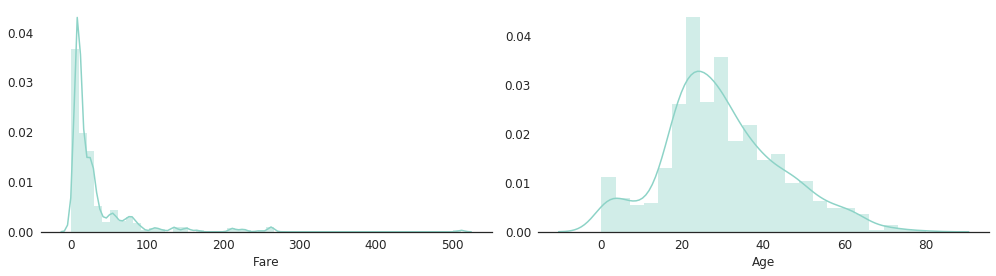

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
sea.distplot(titanic['Fare'].dropna(), ax=axes[0]);
sea.distplot(titanic['Age'].dropna(), ax=axes[1])
sea.despine(left=True)
plt.show()

En la variable `Fare` ya habíamos visto que había una larga cola con un valor extremo de 512.3292 libras (equivalente a 57380.87 GBP de 2018).

In [34]:
titanic[titanic['Fare'].gt(300)]

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,split
PassengerId,,,,,,,,,,,,
259,35.0,NaN,C,512.3292,"Ward, Miss. Anna",0,1,female,0,1.0,PC 17755,train
680,36.0,B51 B53 B55,C,512.3292,"Cardeza, Mr. Thomas Drake Martinez",1,1,male,0,1.0,PC 17755,train
738,35.0,B101,C,512.3292,"Lesurer, Mr. Gustave J",0,1,male,0,1.0,PC 17755,train
1235,58.0,B51 B53 B55,C,512.3292,"Cardeza, Mrs. James Warburton Martinez (Charlo...",1,1,female,0,NaN,PC 17755,test


Esta tarifa corresponde con un ticket compartido por varias personas ocupando 4 ó 5 camarotes. Es un valor extremo, pero dentro de la población.

En las distribuciones de edad no vemos ningún valor anómalo. Destaca, sin embargo, el enorme número de niños, como podemos ver en la siguiente gráfica donde se agrupa la población, separada por sexo, en varias categorías de edad.

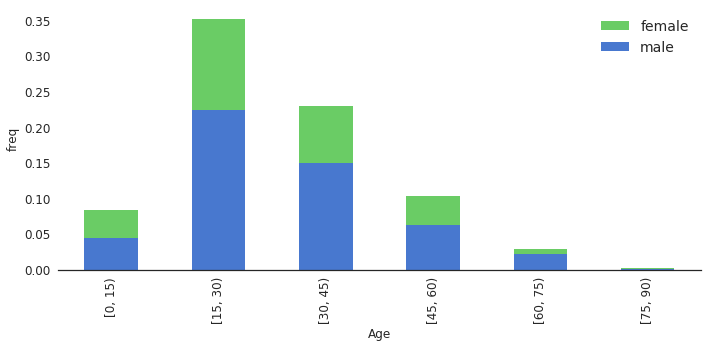

In [35]:
age_bins = range(0, 95, 15)
sex_bins = {}
for i, sex in enumerate(['male', 'female']):
    df = titanic[titanic['Sex'] == sex]
    bins = df.groupby(pd.cut(df['Age'], age_bins, right=False))['Age'].count()
    bins = bins.rename('count').to_frame()
    sex_bins[sex] = bins
sex_bins['female_stacked'] = sex_bins['male'] + sex_bins['female']

N = len(titanic)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
(sex_bins['female_stacked']/N).plot.bar(ax=ax, color='g', label='female', legend=None)
(sex_bins['male']/N).plot.bar(ax=ax, color='b', label='male', legend=None);
ax.legend(['female', 'male']);
ax.set_ylabel('freq');
sea.despine(left=True);

No vamos a hacer nada respecto a los valores extremos encontrados porque son valores dentro de la población y pueden aportar información significativa de cara a predecir la supervivencia. Otro caso es el de los valores perdidos; estos tenemos que tratarlos.

### Variable Embarked 

La distribución de esta variable en el conjunto de entrenamiento es la siguiente.

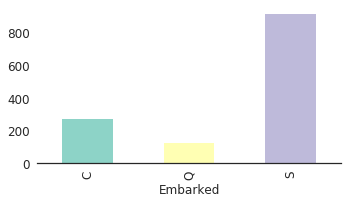

In [36]:
titanic.groupby('Embarked')['Ticket'].size().plot.bar(figsize=(5, 3));
sea.despine(left=True)

Como el número de datos perdidos es pequeño, podemos imputar usando la *moda* (el valor más frecuente) de la muestra: Southampton ('S'). 

Antes de imputar los valores, vamos a añadir una variable binaria al dataset que nos permita mantener un registro de los valores que han sido imputados en caso de que sea necesario en el análisis. Llamamos a esta variable `Embarked_Imputed`.

In [37]:
titanic['Embarked_Imputed'] = titanic['Embarked'].isnull()

Imputamos la moda en los valores perdidos con la función `fillna`.

In [38]:
titanic['Embarked'].fillna(titanic.Embarked.mode()[0], inplace=True)
assert not titanic['Embarked'].isnull().any()

In [39]:
titanic[['Embarked']][titanic.Embarked_Imputed]

,Embarked
PassengerId,
62,S
830,S


### Variable Fare 

Para esta variable solo tenemos un caso perdido en el conjunto de evaluación, podemos imputarlo a partir de la distribución de tarifas en el dataset. 

In [40]:
titanic[titanic['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,split,Embarked_Imputed
PassengerId,,,,,,,,,,,,,
1044,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,3,male,0,NaN,3701,test,False


La distribución de esta variable es compleja porque, como hemos visto, no sólo depende de la categoría del billete. Hay billetes con múltiples pasajeros y múltiples camarotes.

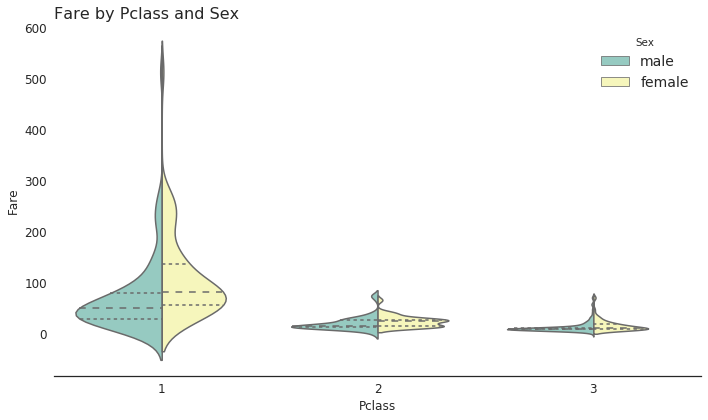

In [41]:
sea.violinplot(x='Pclass', y='Fare', hue='Sex', 
               data=titanic, inner='quart', split=True);
sea.despine(left=True)
plt.title("Fare by Pclass and Sex", loc='left');

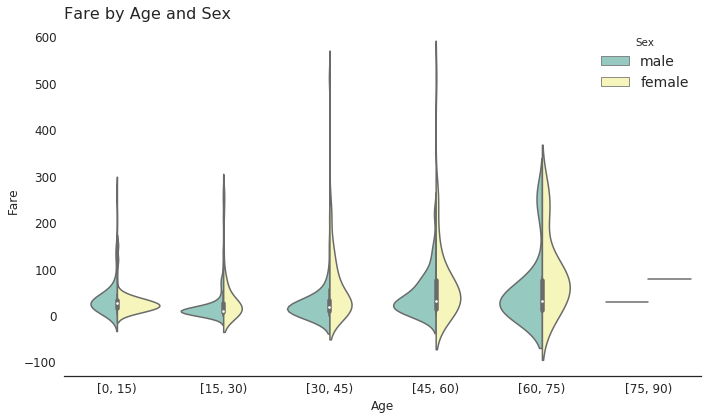

In [42]:
age_bins = pd.cut(titanic['Age'], range(0, 95, 15), right=False)
sea.violinplot(x=age_bins, y='Fare', hue='Sex', split=True, data=titanic);
sea.despine(left=True)
plt.title("Fare by Age and Sex", loc='left');

Se aprecia que en general las mujeres pagaban más por su billete que los hombres. La edad no es un factor muy relevante para las tarifas de los hombres.  

Este dato perdido pertenece a  un hombre que viajaba en tercera clase, en principio, solo.

In [43]:
titanic['Ticket'].eq('3701').sum()

1

Vamos a imputar la tarifa perdida con la mediana de las tarifas para hombres que viajaban solos en tercera clase. En general, si hubiera más datos perdidos, podría ser necesario usar otra estrategia.

In [44]:
titanic[titanic.SibSp.eq(0) & titanic.Parch.eq(0)].groupby(['Pclass', 'Sex'])['Fare'].agg(['median', 'mad'])

median        mad
Pclass Sex                        
1      female  84.82915  65.133665
       male    29.85000  26.179272
2      female  13.00000   3.990580
       male    13.00000   6.444180
3      female   7.77500   1.322063
       male     7.88750   2.825892

Y también como hemos hecho hasta ahora, añadimos una variable para recordar las imputaciones.

In [45]:
# Track nulls/imputed variables
titanic['Fare_Imputed'] = titanic['Fare'].isnull()

# Impute our lost fare
titanic.loc[1044, 'Fare'] = 7.8875

assert titanic.Fare.isnull().sum() == 0

### Variable Age 

Para la variable `Age` tenemos muchos más datos perdidos. Alrededor de un 20% en cada *split*. 

In [46]:
round(titanic[['Age']].isnull().sum()[0] / len(titanic), 2)

0.2

Podemos intuir que esta variable va a influir en la supervivencia. Es conocido que durante la tragedia se priorizó el salvamento de los niños y las mujeres. Es de esperar que esto este representado en los datos. Quizás sea posible derivar información sobre la edad de otras variables, como el título presente en el nombre, pero todavía parece que `Age` es lo bastante interesante como para tratar de imputar estos valores.

In [47]:
titanic[['Age']].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1046.0,29.881138,14.413493,0.17,21.0,28.0,39.0,80.0


Las distribuciones de edades para ambos sexos son muy similares. Estas distribuciones no son gaussianas, son bimodales (debido al número de niños pequeños) y vemos que la población decrece rápidamente con la edad.

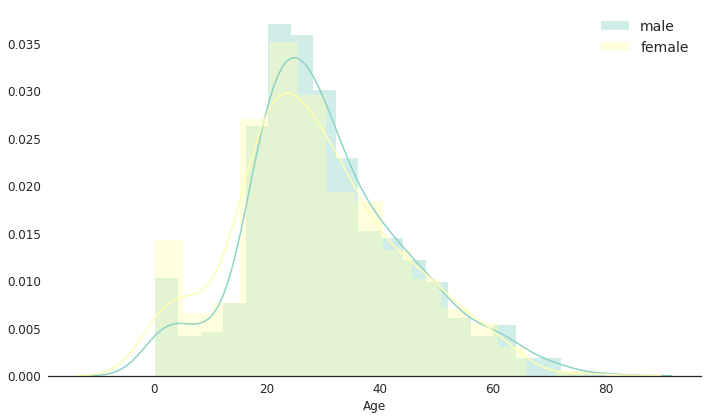

In [48]:
age_df = titanic.dropna(subset=['Age'])
for gender in age_df.Sex.unique():
    sea.distplot(age_df.loc[age_df.Sex == gender, 'Age'], label=gender);
plt.legend();
sea.despine(left=True);

En la siguiente gráfica cada punto representa un pasajero distribuido por edad y supervivencia. 

Parece que la influencia de la edad solo es relevante en ciertos grupos, como los niños o personas mayores.

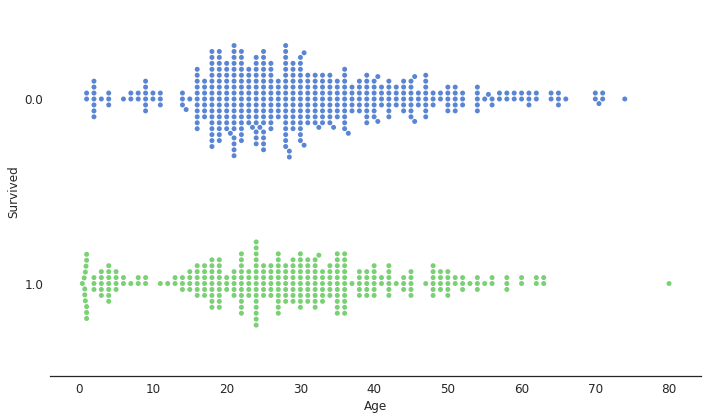

In [49]:
sea.swarmplot(x='Age', y='Survived', data=titanic,
               orient='h', palette='muted', alpha=.9, dodge=False);
sea.despine(left=True)

In [50]:
# Track imputed ages
titanic['Age_Imputed'] = titanic['Age'].isnull()

Para imputar la variable vamos a dividir la población en grupos de edad según el título que llevan en el nombre y asignaremos a los valores perdidos la mediana (estadístico más robusto que la media) de su grupo.

Vamos a empezar extrayendo el título de los nombres y creando una nueva variable con ellos.

In [51]:
titanic['Title'] = titanic.Name.str.extract(r', ([^.]+)\.')

In [52]:
print(sorted(titanic.Title.unique()))

['Capt', 'Col', 'Don', 'Dona', 'Dr', 'Jonkheer', 'Lady', 'Major', 'Master', 'Miss', 'Mlle', 'Mme', 'Mr', 'Mrs', 'Ms', 'Rev', 'Sir', 'the Countess of']


Anora notamos que hay títulos que son variantes regionales. Lo que buscamos es relacionar el título con la edad. Vamos por tanto a reducir el conjunto de títulos.

In [53]:
title_dict = {
    'Miss': ['Mlle', 'Ms', 'Mme'],
    'Master': [],
    'Mrs': ['Dona', 'Lady', 'the Countess of'],
    'Mr': ['Capt', 'Col', 'Don', 'Jonkheer', 'Major', 'Sir', 'Dr', 'Rev'],
}

title_mapping = {value: key 
                 for key, values in title_dict.items()
                 for value in values}

titanic['TitleBin'] = titanic.Title.replace(title_mapping).astype('category')
# Correct females in Mr
titanic.loc[titanic.TitleBin.eq('Mr') & titanic.Sex.eq('female'), 'TitleBin'] = 'Mrs'
# Correct kids in Mr
titanic.loc[titanic.TitleBin.eq('Mr') & titanic.Age.lt(15), 'TitleBin'] = 'Master'

Vemos a continuación las distribuciones de edad en cada grupo.

In [54]:
age_from_title = titanic.groupby('TitleBin')['Age'].agg(['median', 'min', 'max'])
age_from_title

,median,min,max
TitleBin,,,
Master,6.0,0.33,14.5
Miss,22.0,0.17,63.0
Mr,30.0,15.00,80.0
Mrs,36.0,14.00,76.0


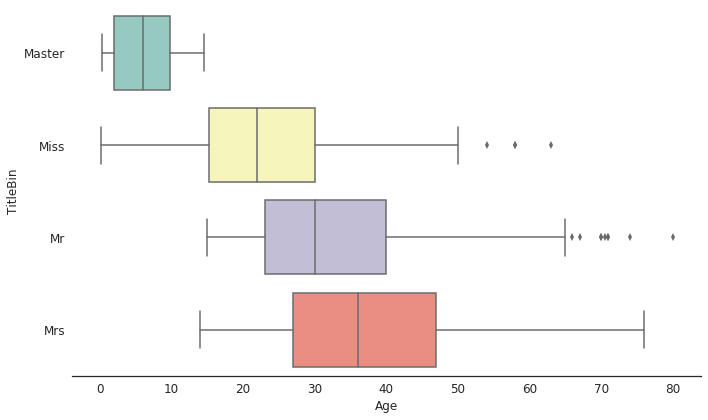

In [55]:
sea.boxplot(y='TitleBin', x='Age', data=titanic, orient='h');
sea.despine(left=True);

Ahora podemos imputar la edad con estos datos.

In [56]:
titanic.loc[titanic.Age_Imputed, 'Age'] = (
    titanic.TitleBin[titanic.Age_Imputed]
        .replace(age_from_title['median'].to_dict()))

En la siguiente gráfica podemos ver la distribución de los valores imputados comporados con los originales.

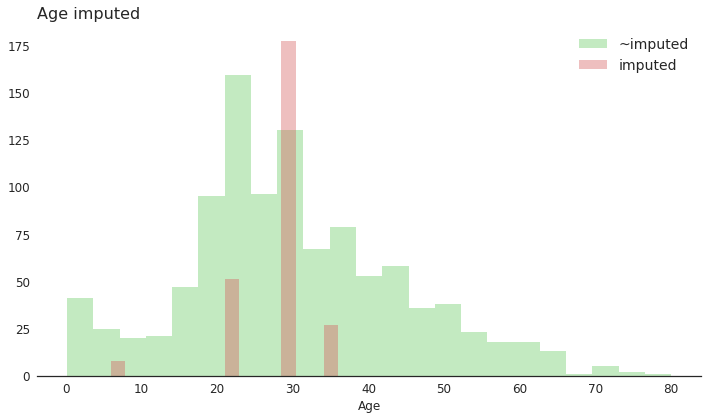

In [57]:
sea.distplot(titanic.Age[~titanic.Age_Imputed], kde=False, color='g', label='~imputed')
sea.distplot(titanic.Age[titanic.Age_Imputed], kde=False, color='r', label='imputed');
plt.legend();
plt.title("Age imputed", loc='left');
sea.despine(left=True);

### Variable Cabin 

De la variable `Cabin` se han perdido más del 77% de los datos. No parecer haber ninguna relación trivial entre el número del billete y el del camarote. Además, puede haber varios camarotes asignados al mismo billete.

In [58]:
titanic[['Cabin', 'Ticket']].dropna().sort_values('Ticket').head(10)

,Cabin,Ticket
PassengerId,,
760,B77,110152
505,B79,110152
258,B77,110152
559,E67,110413
263,E67,110413
586,E68,110413
111,C110,110465
476,A14,110465
1227,C106,110469


Quizas se podría imputar al menos la letra de la cubierta, pero también hay tickets con pasajeros en distintas cubiertas.

Dado el enorme número de datos perdidos no está claro que valor se podría extraer de esta variable que no este contenido en las otras. Por esta razones decidimos prescindir de esta variable.

In [59]:
titanic.drop(columns=['Cabin'], inplace=True)

### Validación 

Validamos una última vez los datos para aseguranos que no hemos cometido ningún error.

In [60]:
display(titanic.describe(include='all').fillna('').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,1309,,,,29.5704,13.1364,0.17,22,30,36,80
Embarked,1309,3,S,916,,,,,,,
Fare,1309,,,,33.2761,51.7436,0,7.8958,14.4542,31.275,512.329
Name,1309,1307,"Kelly, Mr. James",2,,,,,,,
Parch,1309,,,,0.385027,0.86556,0,0,0,0,9
Pclass,1309,,,,2.29488,0.837836,1,2,3,3,3
Sex,1309,2,male,843,,,,,,,
SibSp,1309,,,,0.498854,1.04166,0,0,0,1,8
Survived,891,,,,0.383838,0.486592,0,0,0,1,1
Ticket,1309,929,CA. 2343,11,,,,,,,


Finalmente guardamos una copia en formato CSV.

In [61]:
# sort the columns alphabetically
titanic.sort_index(1, inplace=True)
titanic.to_csv('../data/titanic_clean.csv')

## Análisis 

Partimos de los datos preprocesados en la etapa anterior.

In [62]:
titanic = pd.read_csv("../data/titanic_clean.csv", index_col='PassengerId')
# Convert categorical variables to type category 
for c in titanic:
    if titanic[c].dtype == np.object:
        titanic[c] = titanic[c].astype('category')

Extraemos el split de entrenamiento para analizar la supervivencia de los pasajeros.

In [63]:
titanic_train = titanic[titanic.split == 'train']

### Normalidad y homocedasticidad

Primero analizamos la normalidad de las variables numericas y la homogeneidad en la varianza para las distribuciones por sexo y supervivencia.

Para la normalidad usamos el test de Anderson-Darling con un nivel de significancia del 1%. Para la evaluar la igualdad de las varianzas de las poblaciones usamos la prueba de Levene.

In [64]:
print("Anderson-Darling test for normality (sig 1%)")
print("Equality of variance with Levene test")
print()

df = titanic_train

for c in df:
    if c in ('Survived', 'split') or c.endswith('Bin') or c.endswith("_Imputed"):
        continue
        
    try:
        test_ = stats.anderson(df[c])
    except TypeError:
        continue
    
    # If the statistic is larger than the critical values, then
    # for the corresponding significant level, the null hypothesis
    # can be rejected.
    hypothesis_rejected = test_.statistic > test_.critical_values[-1]
    print(f"{c:<10s}",
          ~hypothesis_rejected,
          f"(statistic: {test_.statistic:.3})", sep="\t")
    
    x_sex = {sex: titanic.loc[titanic.Sex.eq(sex), c]
             for sex in ('female', 'male')}
    x_survived = {s: titanic.loc[titanic.Survived.eq(s), c]
                 for s in (1, 0)}
    
    for sex, x in x_sex.items():
        test_ = stats.anderson(x)
        hypothesis_rejected = test_.statistic > test_.critical_values[-1]
        print(f"- Sex = {sex}",  
              ~hypothesis_rejected,
              f"(statistic: {test_.statistic:.3})", sep="\t")

    for survived, x in x_survived.items():
        test_ = stats.anderson(x)
        hypothesis_rejected = test_.statistic > test_.critical_values[-1]
        print(f"- Survived = {survived}",  
              ~hypothesis_rejected,
              f"(statistic: {test_.statistic:.3})", sep="\t")

    test_ = scipy.stats.levene(x_sex['male'], x_sex['female'])
    hypothesis_rejected = test_.statistic > test_.pvalue
    print(f"- Eq. variance sex: {not hypothesis_rejected}")

    test_ = scipy.stats.levene(x_survived[1], x_survived[0])
    hypothesis_rejected = test_.statistic > test_.pvalue
    print(f"- Eq. variance survived: {not hypothesis_rejected}")


Anderson-Darling test for normality (sig 1%)
Equality of variance with Levene test

Age       	False	(statistic: 10.0)
- Sex = female	False	(statistic: 4.74)
- Sex = male	False	(statistic: 17.6)
- Survived = 1	False	(statistic: 1.81)
- Survived = 0	False	(statistic: 11.0)
- Eq. variance sex: False
- Eq. variance survived: False
Fare      	False	(statistic: 1.22e+02)
- Sex = female	False	(statistic: 55.6)
- Sex = male	False	(statistic: 1.28e+02)
- Survived = 1	False	(statistic: 36.9)
- Survived = 0	False	(statistic: 76.7)
- Eq. variance sex: False
- Eq. variance survived: False
Parch     	False	(statistic: 1.76e+02)
- Sex = female	False	(statistic: 59.1)
- Sex = male	False	(statistic: 2.07e+02)
- Survived = 1	False	(statistic: 54.5)
- Survived = 0	False	(statistic: 1.25e+02)
- Eq. variance sex: False
- Eq. variance survived: False
Pclass    	False	(statistic: 1.1e+02)
- Sex = female	False	(statistic: 48.6)
- Sex = male	False	(statistic: 1.12e+02)
- Survived = 1	False	(statistic: 32.2)
-

### Correlaciones

Ahora nos podemos preguntar que factores influyen más en la supervivencia de los pasajeros del titanic. Podemos analizar la correlación de las variables usando el coeficiente del rango de Spearman.

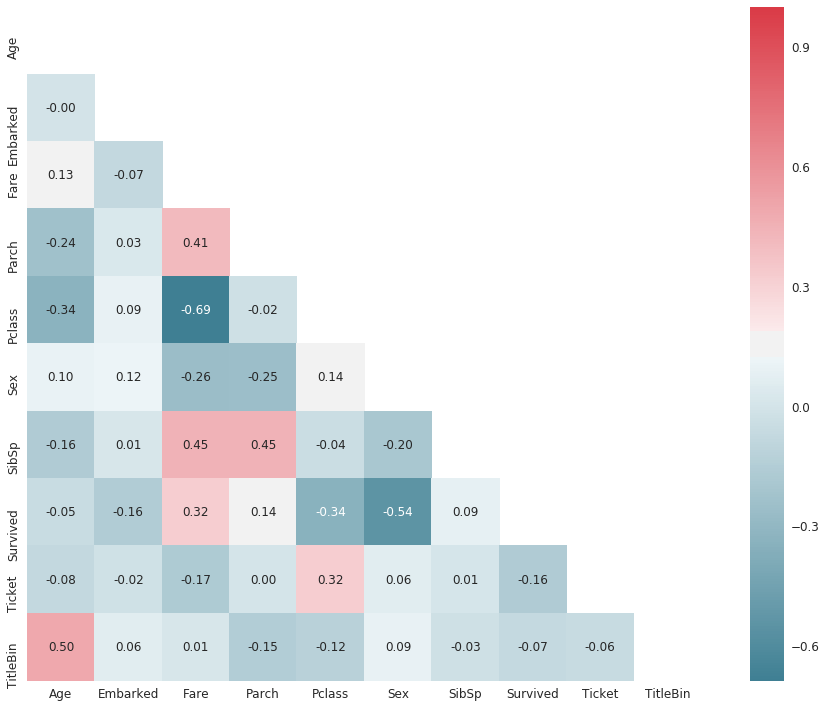

In [65]:
def display_correlation(corr, title=None):
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    plt.figure(figsize=(14, 10))
    cmap = sea.diverging_palette(220, 10, as_cmap=True)
    sea.heatmap(corr, mask=mask, cmap=cmap, annot=True, fmt='.2f', square=True);
    if title:
        plt.title(title, loc='left') 

df = titanic_train
# hide imputed variables
df = df[[c for c in titanic if not c.endswith('_Imputed')]].copy()

# Convert categorical to codes
for var in ['Sex', 'Embarked', 'Ticket', 'TitleBin']:
    df[var] = df[var].cat.codes

corr = df.corr(method='spearman')

display_correlation(corr);

De esta matriz de correlación se destacan varias cosas en relación a la supervivencia.

- Las mujeres tuvieron ventaja sobre los hombres. 
- Viajar en primera clase valió la pena.
- Tener padres (o hijos) a bordo también ayudo.
- Tener hermanos o esposos también, pero menos.
- El puerto de embarque también es significativo, pero seguramente se explica por su correlación con la clase del billete o los grupos de pasajeros.
- La edad no influyó tanto en la supervivencia.
- El orden de los tickets está correlacionado con la clase del billete y con las familias (comparten el mismo billete) y esto los relaciona con la supervivencia. Esto además nos sugiere algo sobre el conjunto de evaluación.

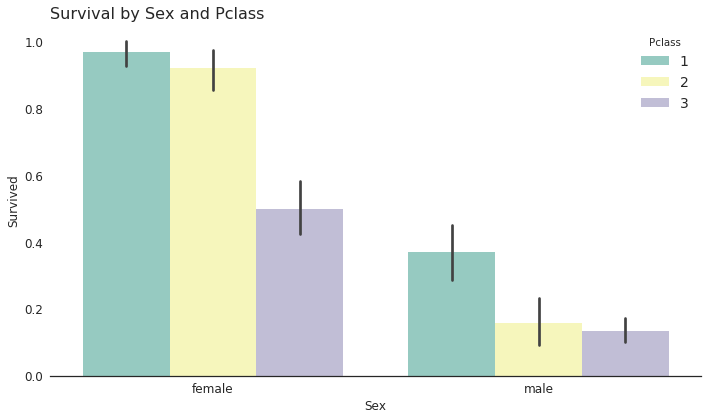

In [66]:
sea.barplot(x='Sex', y='Survived', hue='Pclass', data=titanic);
plt.title('Survival by Sex and Pclass', loc='left');
sea.despine(left=True);

Ahora es muy obvio que el sexo y la clase son factores decisivos.

In [67]:
survival = titanic_train.groupby(['Sex'])['Survived'].agg(['sum', 'count']) 
survival = round(survival['sum'] / survival['count'], 2).to_frame()
survival.columns = ['Survival']
survival

,Survival
Sex,
female,0.74
male,0.19


El 74% de las mujeres sobreviveron, frente a solo el 19% de los hombres.

Pero no todas las mujeres tenían la misma ventaja.

In [68]:
survival = titanic_train.groupby(['Pclass', 'Sex'])['Survived'].agg(['sum', 'count']) 
survival = round(survival['sum'] / survival['count'], 2).to_frame()
survival.columns = ['Survival']
survival

Survival
Pclass Sex             
1      female      0.97
       male        0.37
2      female      0.92
       male        0.16
3      female      0.50
       male        0.14

Un 97% de las mújeres de primera clase sobreviveron a la tragedia. En segunda clase la suerte también estaba del lado de las mujeres. En tercera clase la probabilidad de sobrevivir cae al 50%.

Para los hombres la probabilidad de sobrevivir en primera clase es el doble que en la tercera clase. Los hombres de la segunda clase no parecen gozar de la misma ventaja.

¿Cuanto influye la edad?

Hemos visto que la eda tiene muy poca correlación con la supervivencia.

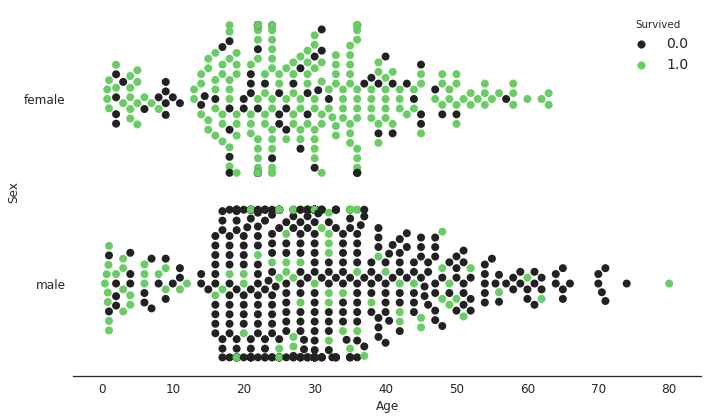

In [69]:
sea.swarmplot(x='Age', y='Sex', hue='Survived', orient='h', 
              data=titanic_train, color='g', size=8);
sea.despine(left=True);

En esta gráfica de las distribuciones de edad según la supervivencia y el sexo, se aprecia que, para los hombres, tener menos de 10 años es una ventaja. Aparte de esto, no se puede decir mucho más. El sexo es un factor mucho más importante.

Ya hemos visto que la mayor parte de los pasajeros embarcaron en Southampton. Podemos ver como se distribuyeron también por clases.

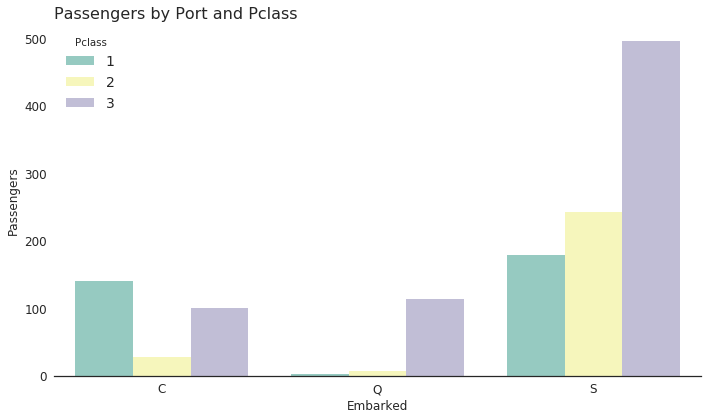

In [70]:
var_df = (titanic.reset_index()
           .groupby(['Embarked', 'Pclass'])['PassengerId']
           .count()
           .to_frame()
           .rename(columns={'PassengerId': 'Passengers'})
           .reset_index())
sea.barplot(x='Embarked', y='Passengers', hue='Pclass', data=var_df)
plt.title("Passengers by Port and Pclass", loc='left')
sea.despine(left=True)

La mayoría de los pasajeros de Southampton iban en tercera clase. La mayoría del pasaje de Cherbourg iba en primera.

Hemos visto que el puerto de embarque influye en la supervivencia.

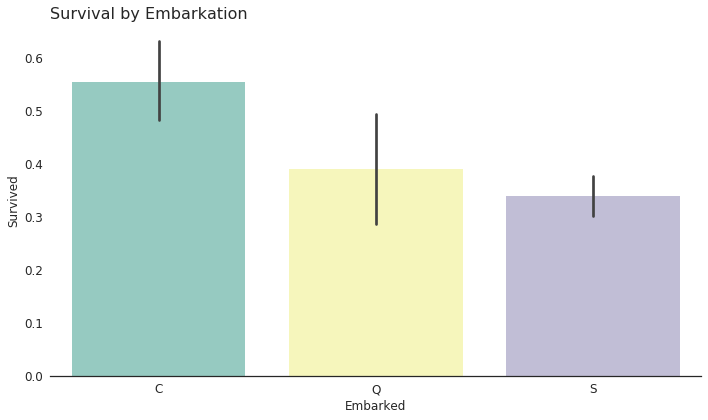

In [71]:
sea.barplot(x='Embarked', y='Survived', data=titanic);
sea.despine(left=True)
plt.title("Survival by Embarkation", loc='left');

### Feature engineering

En este punto tenemos información para buscar nuevas variables con fuerza predictiva.

Vamos a simplificar la variable `Age` categorizándola en varios grupos y la vamos a agregar al dataset.

In [72]:
titanic['AgeBin'] = pd.qcut(titanic.Age, 4)

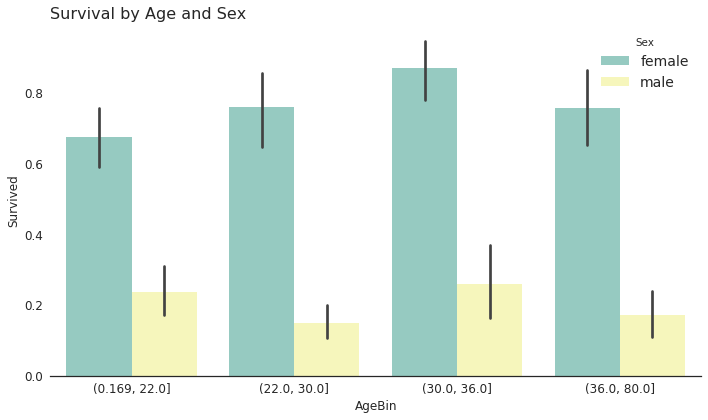

In [73]:
sea.barplot(x='AgeBin', y='Survived', hue='Sex', data=titanic);
sea.despine(left=True)
plt.title("Survival by Age and Sex", loc='left');

Vamos a categorizar también las tarifas en 5 cuantiles.

In [74]:
titanic['FareBin'] = pd.qcut(titanic['Fare'], 5)

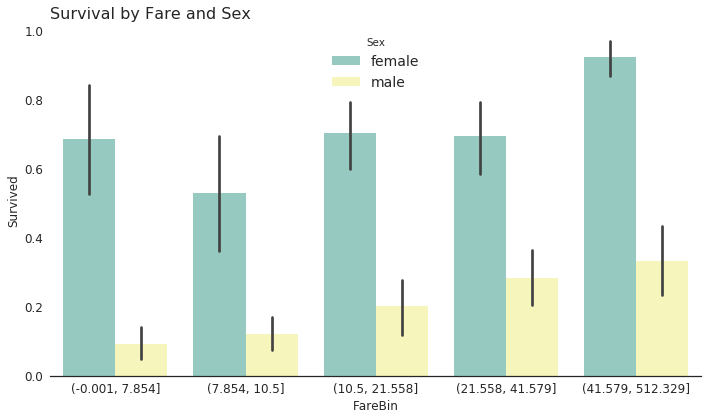

In [75]:
sea.barplot(x='FareBin', y='Survived', hue='Sex', data=titanic);
sea.despine(left=True)
plt.title("Survival by Fare and Sex", loc='left');

Hemos visto que las familias y los grupos de pasajeros están correlacionados con la supervivencia. Nos interesaría encontrar características que reflejen esta relación. 

Aquí intentemos agrupar a las familias por su apellido y el precio que pagaron (el ticket es menos efectivo porque hay familias con diferentes billetes). E identificamos a los grupos por el billete dentro del grupo de pasajeros sin familia.

In [76]:
def update_with(df, o_df):
    """Update a dataframe with data from another one using 
    the other dataframe index."""
    for c in o_df:
        if c not in df:
            df[c] = np.nan
    index_name = df.index.name
    df = df.reset_index().set_index(o_df.index.name)
    df.update(o_df)
    df = df.reset_index().set_index(index_name)
    return df

In [77]:
# Family name
titanic['FamilyName'] = titanic.Name.str.extract('([^,]+),')
# Size of the closest family
titanic['FamilySize'] = (titanic.SibSp + titanic.Parch)

# Here we approximate the families by their last name, the class and the fare
# We don't use Ticket because there are families with several tickets
titanic['Family'] = (titanic.FamilyName
                     .str.cat(titanic.Pclass.astype(str), sep='-')
                     .str.cat(titanic.Fare.astype(str), sep='-'))

# Count the size of the families/groups
families = titanic.groupby('Family').size().to_frame()
families.columns = ['GroupCount']
# Update dataset with this feature
titanic = update_with(titanic, families)

# Potential passengers traveling solo
solos = titanic.GroupCount.eq(1) & titanic.FamilySize.eq(0)
# Update their family name
titanic.loc[solos, 'Family'] = (titanic.loc[solos, 'Ticket'].str
                                .replace(r'^(.+)$', 'SOLO-\\1'))
# Compute size of groups and update FamilySize
groups = titanic[solos].groupby('Family').size()
groups = groups[groups.gt(1)].to_frame()
groups.columns = ['FamilySize']
groups['FamilySize'] -= 1
# Update titanic with group features
titanic = update_with(titanic, groups)

Ahora que tenemos a los pasajeros agrupados, buscamos crear una característica que refleje el nivel de supervivencia de las familias/grupos. La idea es que, al menos para las mujeres y los niños, la supervivencia de cada miembro está relacionada con la supervivencia del grupo.

In [78]:
# Initialize family survival with 0 - neutral
titanic['FamilySurvival'] = 0.0

# Traverse all family members and give +1 if any other member survived,
# else give -1 if any other member perished
for group_index, group in titanic.groupby('Family'):
    if len(group) == 1: continue
    for passenger in group.itertuples():
        others = group.drop(passenger.Index)['Survived']
        if others.count():
            fs = 1 if others.eq(1).any() else -1
            titanic.loc[passenger.Index, 'FamilySurvival'] = fs

# Traverse groups and update
for group_index, group in titanic.groupby('Ticket'):
    if len(group) == 1: continue
    for passenger in group.itertuples():
        if passenger.FamilySurvival <= 0:
            others = group.drop(passenger.Index)['Survived']
            if others.count():
                fs = 1 if others.eq(1).any() else -1
                titanic.loc[passenger.Index, 'FamilySurvival'] = fs

El objetivo de este análisis es crear un modelo para predecir la supervivencia de los pasajeros. En la competención de kaggle los modelos se evaluación según su precisión (*accuracy*), utilizaremos también esta métrica.

In [79]:
from sklearn.metrics import accuracy_score

Es importante empezar con alguna referencia que nos sirva de guía sobre como de fácil o difícil es predecir la supervivencia.

In [80]:
df = titanic_train
y = df.Survived

def print_baseline(survivors, description):
    acc = accuracy_score(y, survivors) * 100
    chance = survivors.sum() / len(survivors) * 100
    print(f"- {description:40s} {acc:>6.1f}%  ({chance:5.1f}%)")

print("Baseline survival chance in training set: {:.1f}%".format(y.sum() / len(y) * 100))
print("Baseline accuracies:")

survivors = np.ones_like(y)
print_baseline(survivors, 'everybody lives')

survivors = np.zeros_like(y)
print_baseline(survivors, 'everybody dies')

survivors[df.Sex == 'female'] = 1
print_baseline(survivors, 'only males die')

survivors[df.Age.lt(5)] = 1
print_baseline(survivors, 'only males >= 5 die')

survivors[df.Age.ge(2) & df.Pclass.eq(3)] = 0
print_baseline(survivors, 'also, everybody in 3rd class dies') 

del y, df

Baseline survival chance in training set: 38.4%
Baseline accuracies:
- everybody lives                            38.4%  (100.0%)
- everybody dies                             61.6%  (  0.0%)
- only males die                             78.7%  ( 35.2%)
- only males >= 5 die                        79.5%  ( 37.8%)
- also, everybody in 3rd class dies          80.2%  ( 21.1%)


Tenemos varios modelos de referencia:

- Todos los pasajeros sobreviven. Modelo optimista pero no muy práctico con una precisión del 38%.
- Ningún pasajero sobrevive. Este modelo, con una precisión del 62%, es una considerable mejora respecto al anterior y ya empieza a ser útil.
- Todos los hombres perecen. Seguimos mejorando. Con una precisión del 78.7% en el conjunto de entrenamiento pone el listón bastante alto. De hecho, este modelo alcanza una precisión del 76.6% en la tabla de clasificación pública de Kaggle, donde se evalua sobre el 50% de los datos de evaluación.
- Si salvamos a los varones de menos de 5 años seguimos mejorando el modelo dentro del conjunto de entrenamiento.
- Si todos los pasajeros de tercera clase, excepto los bebes, perecen subimos la precisión al 80.2%. En este punto estamos ya, probablemente, haciendo *overfitting* al conjunto de entrenamiento.

## Validación del modelo 

Para evaluar la precisión del modelo a medida que lo vamos modificando vamos a hacer uso de la validación cruzada sobre 8 pliegues (*folds*).

In [81]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import KFold, cross_val_score

In [82]:
def evaluate_classifier(clf, X, y, folds=10, desc='', random_state=12345):
    kfold = KFold(folds, shuffle=True, random_state=random_state)

    accuracy = []
    rocauc = []
    reports = []
    
    for k, (train_index, test_index) in enumerate(kfold.split(X)):
        #print(k, len(train_index))
        if clf.get_params().get('random_state'):
            clf.set_params(random_state=random_state)

        clf.fit(X[train_index], y[train_index])
        y_pred = clf.predict(X[test_index])
        y_true = y[test_index]
        
        score = accuracy_score(y_true, y_pred)
        accuracy.append(score)
        
        score = roc_auc_score(y_true, y_pred)
        rocauc.append(score)
        
        reports.append(classification_report(y_true, y_pred))
    
    print("Accuracy: {}{:.2f} +/- {:.2f}%".format(desc, np.mean(accuracy) * 100, 
                                                  2 * np.std(accuracy) * 100))
    print("ROC-AUC:  {}{:.2f} +/- {:.2f}%".format(desc, np.mean(rocauc) * 100, 
                                                  2 * np.std(rocauc) * 100))
    print("Worst fold:")
    print(reports[np.argmin(accuracy)])
    
    return {'accuracy': accuracy, 'roc-auc': rocauc, 'reports': reports}

## Creando el modelo

Para crear el modelo vamos a utilizar el algoritmo de *nearest neighbors* implementado en *sklearn*. Se han probado otros modelos, como regresión logística, con y sin regularización, o SVM, pero este es el que mejor funciona. Por falta de tiempo no incluímos este análisis aquí.

In [83]:
from sklearn.neighbors import KNeighborsClassifier

Vamos a usar las siguientes caracteristicas: `Pclass, Sex, AgeBin, FareBin, FamilySize, GroupCount, FamilySurvival`. Porque después de varias pruebas son las que mejor resultado han dado.

Codificamos las variables categóricas con las clases `LabelEncoder` y `LabelBinarizer` de `sklearn.preprocessing`. Finalmente estandarizamos las variables eliminando la media y diviendo por la varianza con `sklearn.preprocessing.StandardScaler`.

In [84]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.preprocessing import StandardScaler

data_encoder = DataFrameMapper([
    ('Pclass', LabelBinarizer()),
    ('Sex', LabelEncoder()),
    ('AgeBin', LabelEncoder()),
    ('FareBin', LabelEncoder()),
    ('FamilySize', None),
    ('GroupCount', None),
    ('FamilySurvival', None),
], df_out=True)

# Fit the encoders on the full dataset
data_encoder.fit(titanic)

# We train on the train set
titanic_train = titanic[titanic.split == 'train'].copy()
X = data_encoder.transform(titanic_train).values
y = titanic_train['Survived'].values.astype(float)

# This is for submitting to kaggle
titanic_eval = titanic[titanic.split == 'test'].copy()
X_eval = data_encoder.transform(titanic_eval).values

# Scale all variables
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_eval = scaler.transform(X_eval)

print("Num of features:", X.shape[1])

Num of features: 9


Buscamos los mejores parámetros del clasificador con la ayuda de `GridSearchCV`.

In [85]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(KNeighborsClassifier(),
                           param_grid={
                               'leaf_size': range(30, 100, 20),
                               'n_neighbors': range(2, 10),
                               'weights': ('uniform', 'distance')
                           },
                           cv=8, scoring='roc_auc', verbose=True)
grid_search.fit(X, y)
print("Best score:", grid_search.best_score_)

clf = grid_search.best_estimator_
print(clf)

Fitting 8 folds for each of 64 candidates, totalling 512 fits
Best score: 0.8650016054488122
KNeighborsClassifier(algorithm='auto', leaf_size=50, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=6, p=2,
           weights='uniform')


[Parallel(n_jobs=1)]: Done 512 out of 512 | elapsed:    3.9s finished


In [86]:
clf = grid_search.best_estimator_
evaluate_classifier(clf, X, y, folds=8);

Accuracy: 83.63 +/- 9.06%
ROC-AUC:  81.16 +/- 9.85%
Worst fold:
             precision    recall  f1-score   support

        0.0       0.77      0.89      0.83        65
        1.0       0.81      0.64      0.71        47

avg / total       0.79      0.79      0.78       112



La validación cruzada nos indica una precisión sobre el conjunto de entrenamiento del 83.6%. Un 3.4% sobre el último modelo trivial.

Para reducir el overfitting sobre el conjunto de entrenamiento, vamos a aumentar el parámetro `leaf_size`, cuyo efecto es reducir el número de nodos en el árbol de búsqueda, simplificando el modelo y, por tanto, haciéndolo más general.

In [87]:
clf = KNeighborsClassifier(n_neighbors=9, leaf_size=100)
evaluate_classifier(clf, X, y, folds=8);

Accuracy: 83.18 +/- 8.47%
ROC-AUC:  80.92 +/- 10.12%
Worst fold:
             precision    recall  f1-score   support

        0.0       0.77      0.89      0.83        65
        1.0       0.81      0.64      0.71        47

avg / total       0.79      0.79      0.78       112



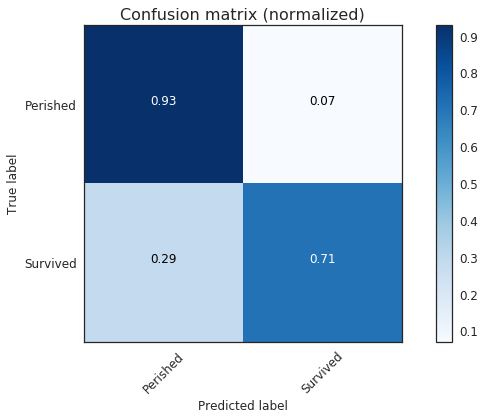

In [88]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        title += " (normalized)"
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plot_confusion_matrix(confusion_matrix(y, clf.predict(X)), 
                      classes=['Perished', 'Survived'], 
                      normalize=True);

La matriz de confusión, por el número de falsos negativos, nos sugiere que el modelo tiende a ser pesimista.

Para hacer predicciones, entrenamos el modelo seleccionado sobre todo el conjunto de entrentamiento. La precisión sobre el conjunto de entrenamiento, lógicamente, es más alta y menos exacta.

In [89]:
clf.fit(X, y)
print("Accuracy on train: {:.1f}%".format(accuracy_score(y, clf.predict(X))*100))
print(classification_report(y, clf.predict(X)))
y_pred = clf.predict(X_eval).astype(int)
titanic_eval['Survived'] = y_pred

Accuracy on train: 85.6%
             precision    recall  f1-score   support

        0.0       0.85      0.93      0.89       549
        1.0       0.86      0.75      0.80       342

avg / total       0.86      0.86      0.85       891



In [90]:
print("Predicted percentage of survivors: {:.1f}%".format(
      (y_pred.sum() / len(y_pred))*100))

Predicted percentage of survivors: 33.3%


Si visualizamos la distribución de supervivientes vemos que el modelo está sesgado hacia la superviviencia de las mujeres y es muy pesimista respecto a la de los hombres. Esto sería algo que se podría intentar mejorar en otra iteración.

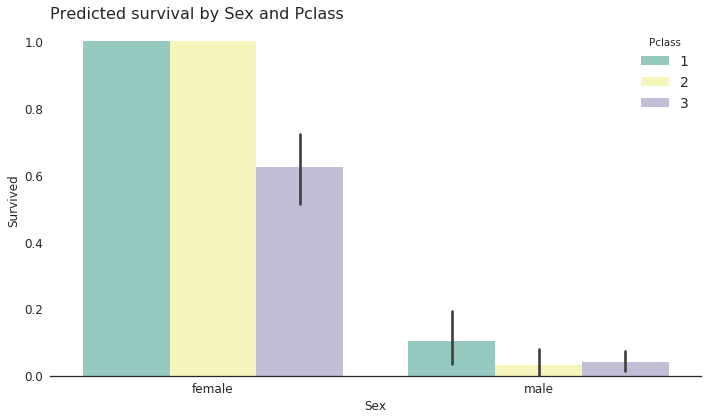

In [91]:
sea.barplot(x='Sex', y='Survived', hue='Pclass', data=titanic_eval);

plt.title('Predicted survival by Sex and Pclass', loc='left');
sea.despine(left=True);

### Evaluando el resultado en Kaggle

Para evaluar el resultado en el tablero de clasificación de la competición lo único que hay que hacer es generar un fichero CSV con los resultados y enviarlo, por ejemplo, usando la API de Kaggle. 

El resultado es una precisión de 0.82775.

In [92]:
def make_submission(y_pred, name):
    name = re.sub(r'\.csv$', '', name)
    filename = f"../output/{name}.csv"
    pd.DataFrame({'Survived': y_pred.astype(int)}, 
                 index=titanic_eval.index).to_csv(filename)
    return filename

In [93]:
filename = make_submission(y_pred, 'submission')
# !kaggle competitions submit -c titanic -f {filename} -m 'KNN'